In [21]:
rm(list=ls())
user_name = Sys.info()['user']
temp_path = Sys.getenv()['TMP']
if (require('LalRUtils')==F) {
    library(devtools)
    devtools::install_github("apoorvalal/LalRUtils")
}
load_or_install(c('tidyverse','magrittr','sp','rgeos','maptools','RColorBrewer','ggmap')) #, "lib2")
sessionInfo()

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

R version 3.3.2 (2016-10-31)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 15063)

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] bindrcpp_0.2         ggmap_2.6.1          RColorBrewer_1.1-2  
 [4] maptools_0.8-39      rgeos_0.3-23         sp_1.2-3            
 [7] magrittr_1.5         dplyr_0.7.1          purrr_0.2.2         
[10] readr_1.0.0          tidyr_0.6.1          tibble_1.3.3        
[13] ggplot2_2.1.0        tidyverse_1.1.1      LalRUtils_0.0.0.9000
[16] jsonlite_1.0        

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.11        lubridate_1.5.6     lattice_0.20-34    
 [4] png_0.1-7           assertthat_0.1      di

In [22]:
dist = readRDS(gzcon(url('http://biogeo.ucdavis.edu/data/gadm2.8/rds/NPL_adm3.rds')))
census_data=readr::read_csv('https://raw.githubusercontent.com/apoorvalal/census-data/master/districts_complete.csv')

Warning message:
"Duplicated column names deduplicated: 'OTHERS' => 'OTHERS_1' [17], 'NOT_STATED' => 'NOT_STATED_1' [18], 'OTHERS' => 'OTHERS_2' [23], 'NOT_STATED' => 'NOT_STATED_2' [24], 'NOT_STATED' => 'NOT_STATED_3' [39], 'ELECTRICITY' => 'ELECTRICITY_1' [46], 'KEROSENE' => 'KEROSENE_1' [47], 'BIOGAS' => 'BIOGAS_1' [48], 'OTHERS' => 'OTHERS_3' [50], 'NOT_STATED' => 'NOT_STATED_4' [51], 'MUD_BONDED' => 'MUD_BONDED_1' [52], 'CEMENT_BONDED' => 'CEMENT_BONDED_1' [53], 'OTHERS' => 'OTHERS_4' [57], 'NOT_STATED' => 'NOT_STATED_5' [58], 'OTHERS' => 'OTHERS_5' [62], 'NOT_STATED_BOTH_SEX' => 'NOT_STATED_BOTH_SEX_1' [143], 'NOT_STATED_MALE' => 'NOT_STATED_MALE_1' [144], 'NOT_STATED_FEMALE' => 'NOT_STATED_FEMALE_1' [145], 'WOOD_PLANKS' => 'WOOD_PLANKS_1' [153], 'OTHERS' => 'OTHERS_6' [155], 'NOT_STATED' => 'NOT_STATED_6' [156], 'NOT_STATED' => 'NOT_STATED_7' [160]"Parsed with column specification:
cols(
  .default = col_integer(),
  DISTRICT = col_character(),
  `VDC/MUNICIPALITY` = col_charact

In [23]:
names(census_data) = tolower(names(census_data))

### Outlines

Regions defined for each Polygons


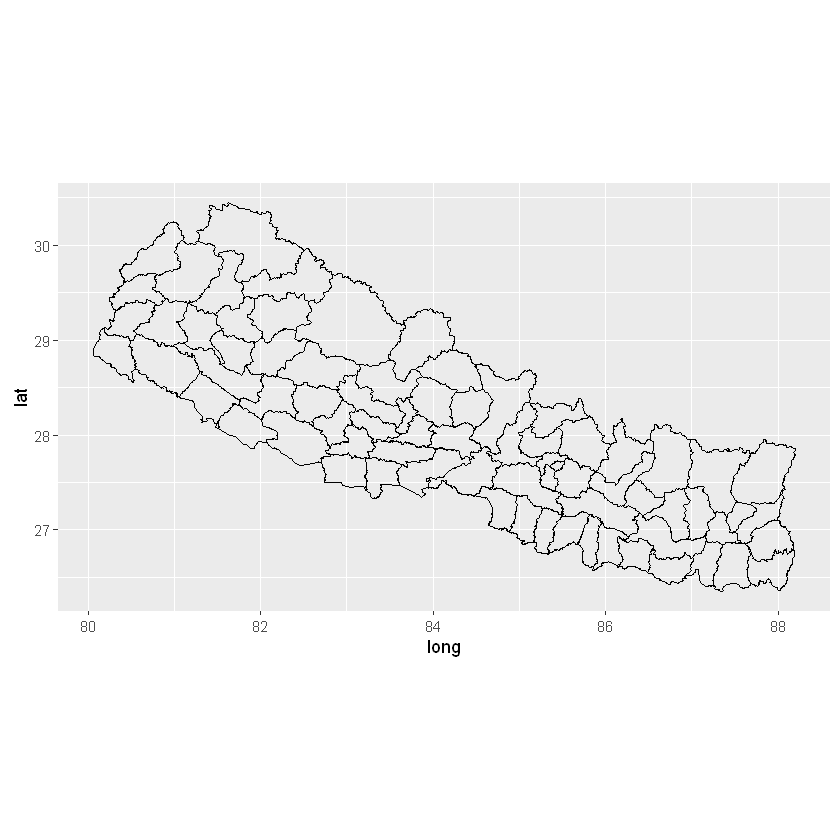

In [24]:
ggplot(data=dist)+geom_path(aes(x=long,y=lat,group=group))+coord_fixed(1.1)

### Fortify shapefile and rename to prep for merge

In [25]:
dist$NAME_3 = tolower(dist$NAME_3)

In [26]:
dist_shp <- fortify(dist, region = "NAME_3")
# Consolidate district names for merge
# if (F) {
#     dim(dist)
#     dim(dist_lev_literacy) # Tanahu is missing for some reason
#     distnames_shp = unique(dist_shp$id)
#     distnames_dat = unique(dist_lev_literacy$district_l)
#     setdiff(distnames_dat,distnames_shp)
#     setdiff(distnames_shp,distnames_dat)
# }
# shapefile name        census name
# "chitawan"            "chitwan"
# "dhanusa"             "dhanusha"
# "ilam"                "illam"
# "kavrepalanchok"      "kavre"
# "makwanpur"           "makawanpur"
# "sindhupalchok"       "sindhupalchowk"
# "terhathum"           "tehrathum"

dist_shp %>%
     mutate(id=replace(id,id== "chitawan"       , "chitwan")) %>%
     mutate(id=replace(id,id== "dhanusa"        , "dhanusha")) %>%
     mutate(id=replace(id,id== "ilam"           , "illam")) %>%
     mutate(id=replace(id,id== "kavrepalanchok" , "kavre")) %>%
     mutate(id=replace(id,id== "makwanpur"      , "makawanpur")) %>%
     mutate(id=replace(id,id== "sindhupalchok"  , "sindhupalchowk")) %>%
     mutate(id=replace(id,id== "terhathum"      , "tehrathum")) -> 
    dist_shp_ren

### Aggregate Census data to District

In [27]:
names(census_data)
table(census_data$district)

[1] "district"                         "vdc/municipality"                
  [3] "wood"                             "kerosene"                        
  [5] "lpg"                              "guitha"                          
  [7] "biogas"                           "others"                          
  [9] "electricity"                      "not_stated"                      
 [11] "tap_piped"                        "tubewell"                        
 [13] "covered_well"                     "uncovered_well"                  
 [15] "spout_water"                      "river_stream"                    
 [17] "others_1"                         "not_stated_1"                    
 [19] "mud_bonded"                       "cement_bonded"                   
 [21] "rcc_with_pillar"                  "wooden_pillar"                   
 [23] "others_2"                         "not_stated_2"                    
 [25] "no_facility"                      "at_least_one"                    
 [27] "radio"                            "television"                      
 [29] "cable_television"                 "computer"                        
 [31] "internet"                         "telephone"                       
 [33] "mobile_phone"                     "motor"                           
 [35] "motorcycle"                       "cycle"                           
 [37] "other_vehicle"                    "refrigerator"                    
 [39] "not_stated_3"                     "household"                       
 [41] "total_population"                 "male_population"                 
 [43] "female_population"                "average_household_size"          
 [45] "sex_ratio"                        "electricity_1"                   
 [47] "kerosene_1"                       "biogas_1"                        
 [49] "solar"                            "others_3"                        
 [51] "not_stated_4"                     "mud_bonded_1"                    
 [53] "cement_bonded_1"                  "wood_planks"                     
 [55] "bamboo"                           "unbacked_brick"                  
 [57] "others_4"                         "not_stated_5"                    
 [59] "owned"                            "rented"                          
 [61] "institutional"                    "others_5"                        
 [63] "male_population_5_25"             "female_population_5_25"          
 [65] "school_going_male"                "school_going_female"             
 [67] "not_going_male"                   "not_going_female"                
 [69] "attendence_not_stated_male"       "attendence_not_stated_female"    
 [71] "no_disability_both_sex"           "no_disability_male"              
 [73] "no_disability_female"             "physical_both_sex"               
 [75] "physical_male"                    "physical_female"                 
 [77] "blindness_low_vision_both_sex"    "blindness_low_vision_male"       
 [79] "blindness_low_vision_female"      "deaf_hearing_both_sex"           
 [81] "deaf_hearing_male"                "deaf_hearing_female"             
 [83] "deaf_blind_both_sex"              "deaf_blind_male"                 
 [85] "deaf_blind_female"                "speech_problem_both_sex"         
 [87] "speech_problem_male"              "speech_problem_female"           
 [89] "mental_disability_both_sex"       "mental_disability_male"          
 [91] "mental_disability_female"         "intellectual_disability_both_sex"
 [93] "intellectual_disability_male"     "intellectual_disability_female"  
 [95] "multiple_disability_both_sex"     "multiple_disability_male"        
 [97] "multiple_disability_female"       "beginner_both_sex"               
 [99] "beginner_male"                    "beginner_female"                 
[101] "primary_1_5_both_sex"             "primary_1_5_male"                
[103] "primary_1_5_female"               "lower_secondary_6_8_both_sex"    
[105] "lower_secondary_6_8_male"         "lower_se


        ACHHAM   ARGHAKHANCHI        BAGLUNG        BAITADI        BAJHANG 
            75             42             60             63             47 
        BAJURA          BANKE           BARA        BARDIYA      BHAKTAPUR 
            27             47             99             32             18 
       BHOJPUR        CHITWAN     DADELDHURA        DAILEKH           DANG 
            63             38             21             56             41 
      DARCHULA        DHADING       DHANKUTA       DHANUSHA        DOLAKHA 
            41             50             36            102             52 
         DOLPA           DOTI         GORKHA          GULMI          HUMLA 
            23             51             67             79             27 
         ILLAM       JAJARKOT          JHAPA          JUMLA        KAILALI 
            49             30             50             30             44 
       KALIKOT     KANCHANPUR     KAPILBASTU          KASKI      KATHMANDU 
           

In [28]:
census_data  %>%
    mutate(gender_diff_literacy = literacy_rate_male-literacy_rate_female,
          district = tolower(district))  %>% 
    group_by(district)  %>%
    summarize(literacy=mean(literacy_rate_both_sex),
           male_literacy=mean(literacy_rate_male),
           female_literacy=mean(literacy_rate_female),
           diff_literacy=mean(gender_diff_literacy)) ->
    dist_lev_literacy
head(dist_lev_literacy)
dim(dist_lev_literacy)

district,literacy,male_literacy,female_literacy,diff_literacy
achham,56.67583,72.02267,43.98457,28.03810
arghakhanchi,72.15724,81.42333,65.54226,15.88107
baglung,71.00933,79.82789,64.56314,15.26474
baitadi,62.81684,78.98610,49.13563,29.85047
bajhang,56.16457,73.95553,40.67472,33.28080
bajura,54.50050,67.80749,42.26080,25.54669


[1] 74  5

In [29]:
# merge district level literacy figures with fortified shapefile
dist_literacy_geo = merge(dist_shp_ren,dist_lev_literacy,
                    by.x='id',by.y='district',all.x=T)
dist_literacy_geo %<>% arrange(order)
cnames <- aggregate(cbind(long, lat) ~ id, data=dist_literacy_geo, 
                    FUN=function(x) mean(range(x)))

### Maps

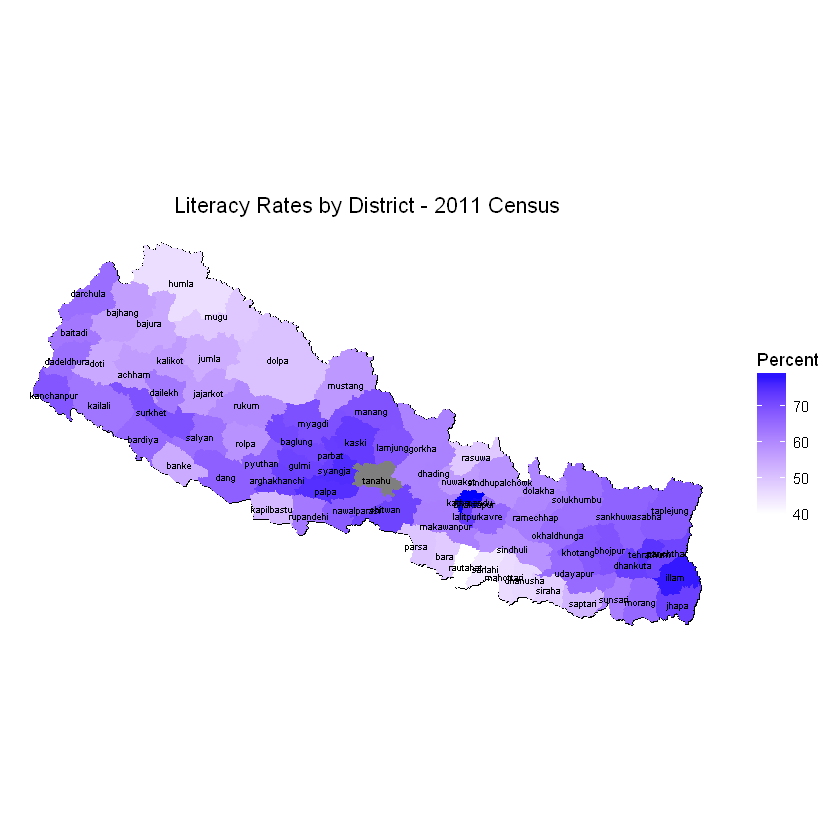

In [31]:
ggplot(data=dist_literacy_geo) +
    geom_path(aes(x=long,y=lat,group = id)) +
    geom_polygon(aes(x=long,y=lat,group = id,fill=literacy
                    )) +
    coord_map()+
    theme_nothing(legend = TRUE)+
    scale_fill_gradient(name="Percent",low="white", high="blue")+
    labs(title = 'Literacy Rates by District - 2011 Census' ) +
    geom_text(data=cnames, aes(long, lat, label = id), size=2)

In [32]:
mlit = ggplot(data=dist_literacy_geo) +
    geom_path(aes(x=long,y=lat,group = id)) +
    geom_polygon(aes(x=long,y=lat,group = id,fill=male_literacy)) +
    coord_map()+
    theme_nothing(legend = TRUE)+
    scale_fill_gradient(name="Percent",low="white", high="blue")+
    labs(title = 'Male Literacy Rates by District - 2011 Census' ) +
    geom_text(data=cnames, aes(long, lat, label = id), size=2)

flit = ggplot(data=dist_literacy_geo) +
    geom_path(aes(x=long,y=lat,group = id)) +
    geom_polygon(aes(x=long,y=lat,group = id,fill=female_literacy)) +
    coord_map()+
    theme_nothing(legend = TRUE)+
    scale_fill_gradient(name="Percent",low="white", high="blue")+
    labs(title = 'Female Literacy Rates by District - 2011 Census' ) +
    geom_text(data=cnames, aes(long, lat, label = id), size=2)

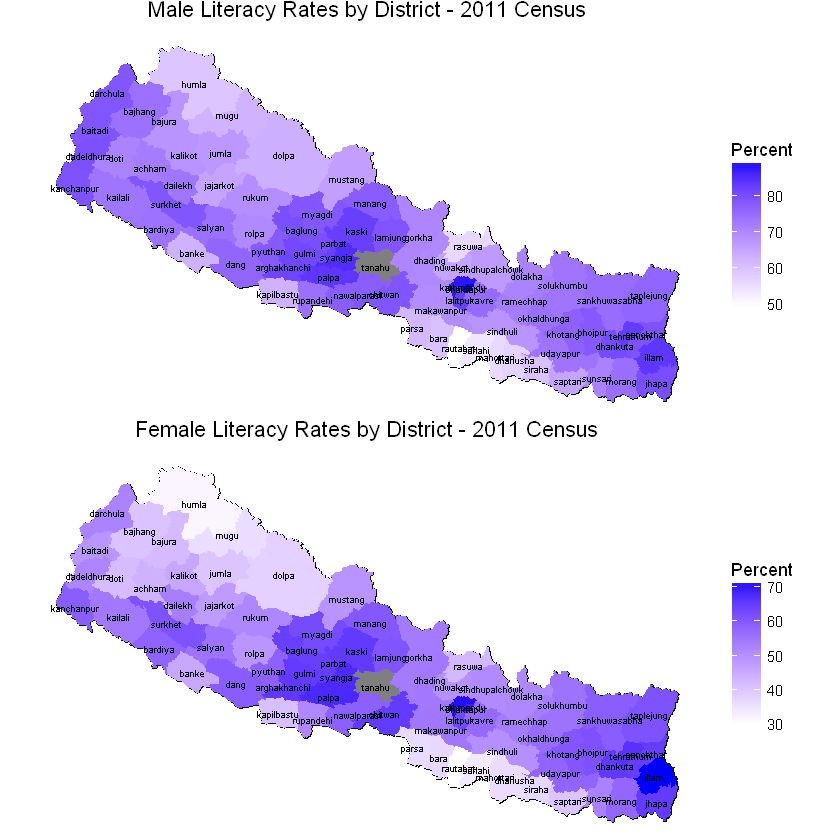

In [33]:
multiplot(mlit,flit)

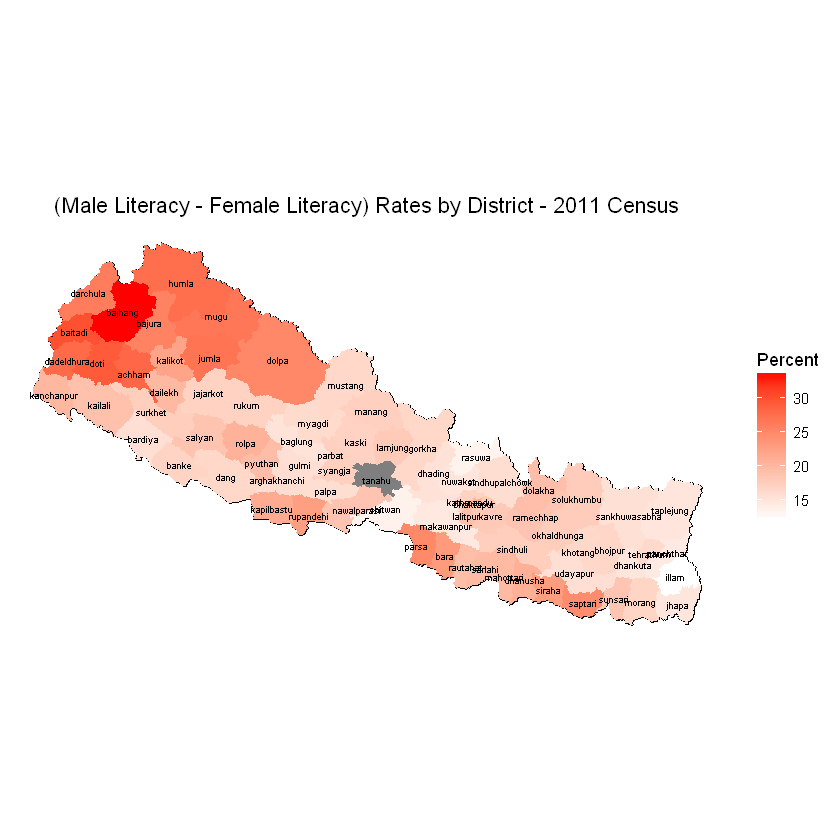

In [34]:
ggplot(data=dist_literacy_geo) +
    geom_path(aes(x=long,y=lat,group = id)) +
    geom_polygon(aes(x=long,y=lat,group = id,fill=diff_literacy)) +
    coord_map()+
    theme_nothing(legend = TRUE)+
    scale_fill_gradient(name="Percent",low="white", high="red")+
    labs(title = '(Male Literacy - Female Literacy) Rates by District - 2011 Census' ) +
    geom_text(data=cnames, aes(long, lat, label = id), size=2)